# TIME SERIES ANALYSIS

## Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


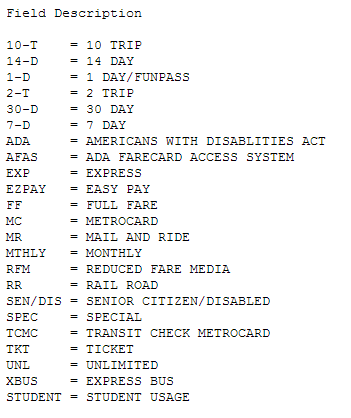

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [21]:
from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as pl
import statsmodels.api as sm

import os
import json
s = json.load( open('fbb_matplotlibrc.json'))
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [33]:
data=np.load( 'MTA_Fare.npy' ).astype('float')
data.shape

(600, 23, 194)

In [34]:
data[data==-1] = np.nan

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

In [35]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

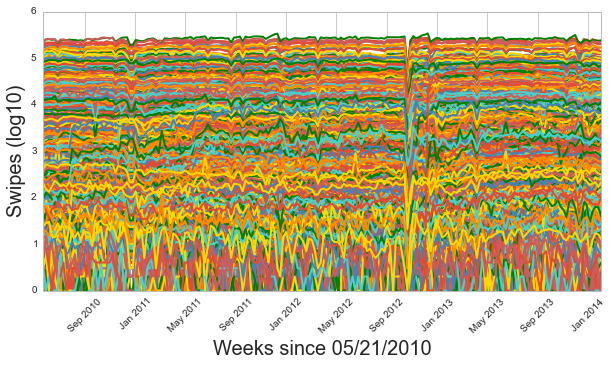

In [43]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

dates = pd.date_range('20100521', periods=194, freq='W')
ax = plt.figure(figsize = (10,5))
for i in range (0, 600):
    for j in range (0, 23):
        plt.plot(dates, np.log10(data[i][j]))
plt.xticks(rotation=45)
plt.xlabel("Weeks since 05/21/2010", fontsize = 20)
plt.ylabel("Swipes (log10)", fontsize = 20)

In [48]:
# Sum up the fare 
datasum_station =np.nansum(data, axis=0)
print (datasum_station.shape)
datasum_ridetype =np.nansum(data, axis=1)
print (datasum_ridetype.shape)

(23, 194)
(600, 194)


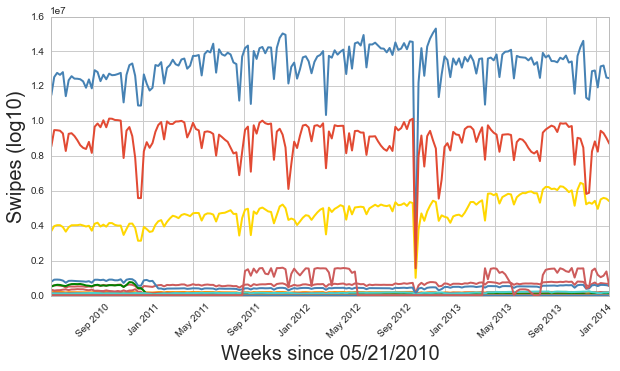

In [49]:
ax1 = plt.figure(figsize = (10,5))
for i in range(0, 23):
    plt.plot(dates, datasum_station[i])
plt.xticks(rotation=45)
plt.xlabel("Weeks since 05/21/2010", fontsize = 20)
plt.ylabel("Swipes (log10)", fontsize = 20)

# I can see a significant drop from the plot, which might be a prominent event happened in Sep 2012. I guess it was the Hurricane Sandy.

In [57]:
df_station= pd.DataFrame(data = datasum_station).dropna().transpose()
df_station.columns = ridetype
df_station.index = dates
sumbytype = df_station.sum(axis = 1)
thresholds = [sumbytype.mean() + 3*sumbytype.std(), 
              sumbytype.mean() - 3*sumbytype.std()]
sumbytype[(sumbytype < thresholds[1]) | (sumbytype > thresholds[0])]

2012-10-21    5218686
Freq: W-SUN, dtype: float64

# According to the detection, the spike is due to a prominent event happened on 10/21/2012, which is the Hurricane Sandy as expected.

# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

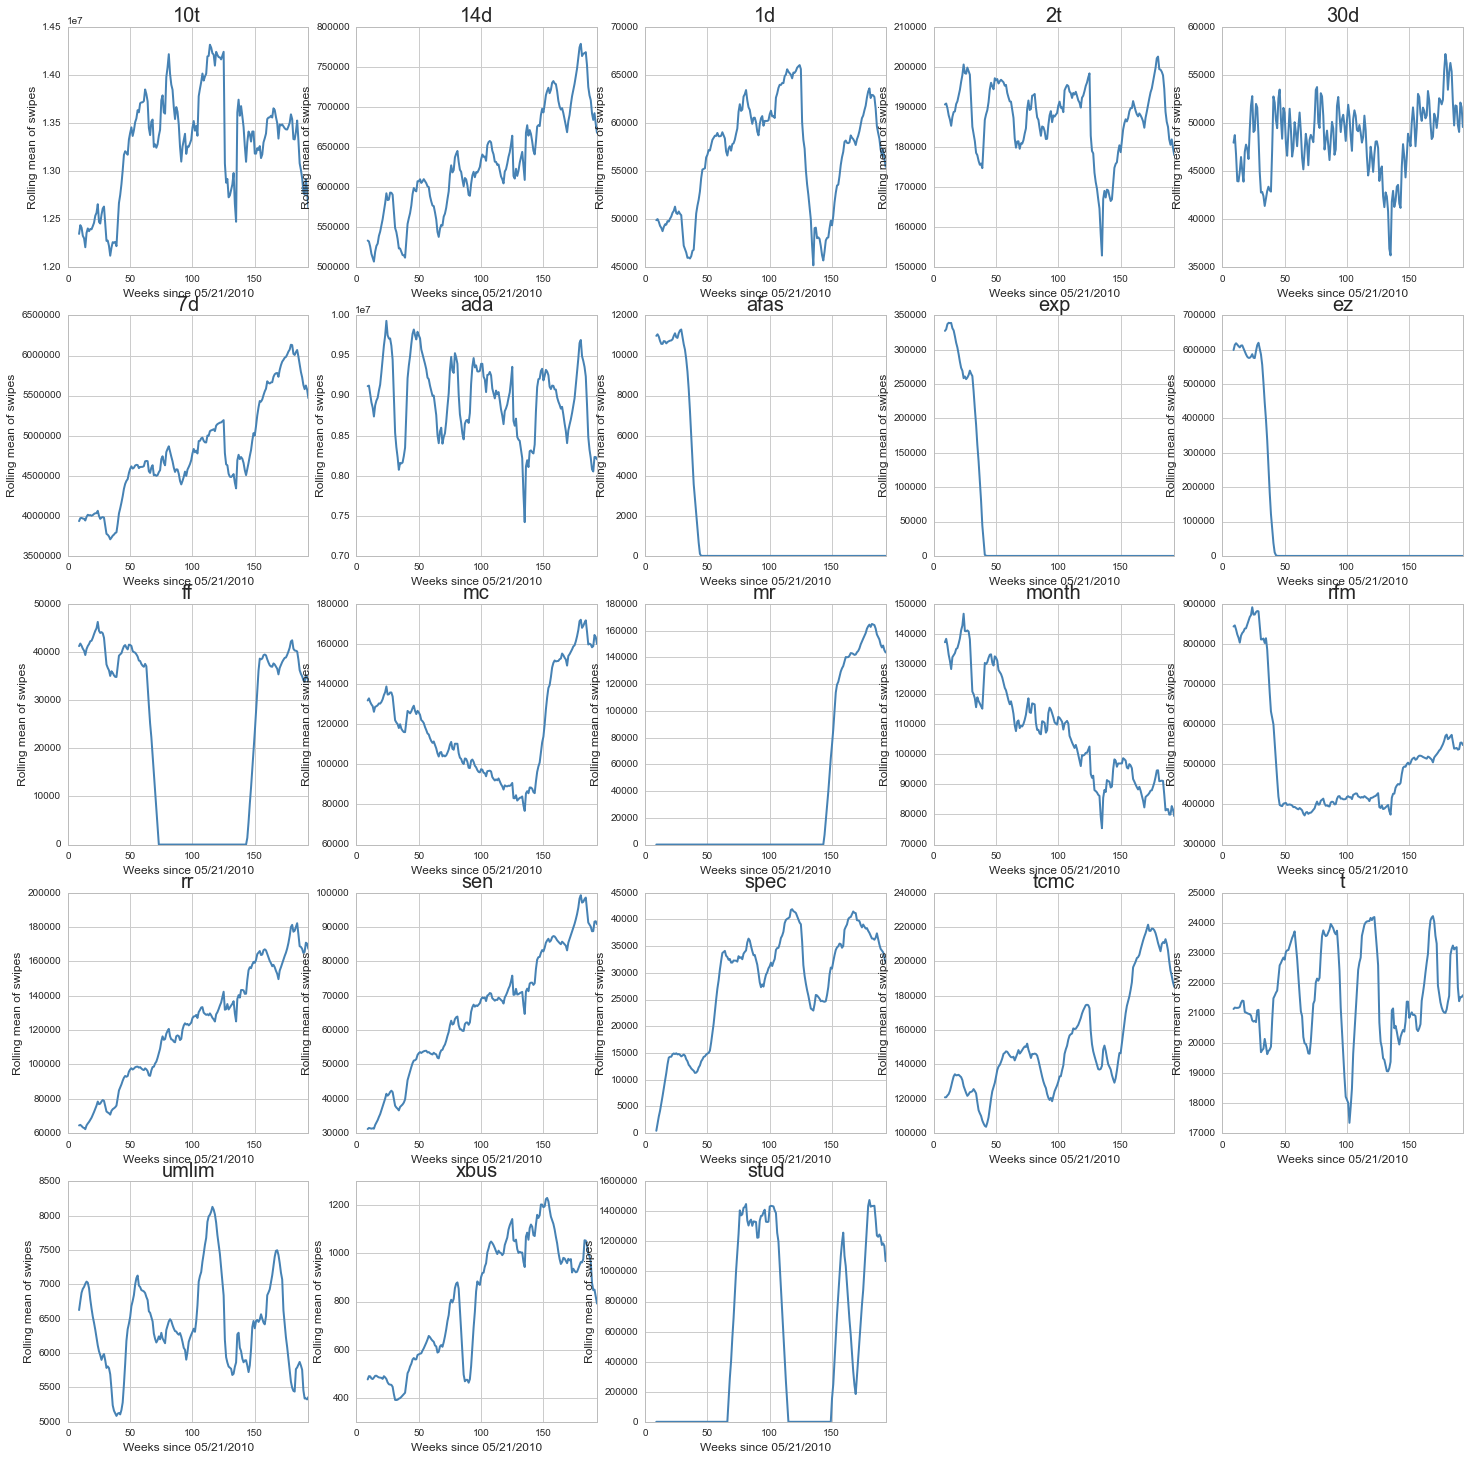

In [97]:
datasum_station = pd.DataFrame(datasum_station)
fig = plt.figure(figsize=(25,25))
for i in range(0,5):
    for j in range(0,5):
        if i*5+j < 23:
            ax = fig.add_subplot(5,5,i*5+j+1)
            ax = pd.rolling_mean(datasum_station.loc[i*5+j], 10).plot()
            ax.set_title(ridetype[i*5+j],fontsize=20)
        plt.xlabel("Weeks since 05/21/2010")
        plt.ylabel("Rolling mean of swipes")

In [91]:
ratiodf = (roll_mean.iloc[-1]/roll_mean.iloc[9])
print ('Increasing:')
ratiodf[ratiodf > 1].head(10).sort_values(ascending=0)

Increasing:


mr      24784.931034
spec       70.182379
sen         2.909397
rr          2.592960
7d          1.389748
14d         1.252065
mc          1.213541
1d          1.111345
30d         1.033787
10t         1.021798
dtype: float64

In [90]:
print ('Decreasing:')
ratiodf[ratiodf < 1].head(10).sort_values(ascending=0)

Decreasing:


2t       0.933803
ada      0.899841
ff       0.818802
umlim    0.809064
rfm      0.649608
month    0.578722
afas     0.000209
exp      0.000011
ez       0.000002
dtype: float64

# The graphs above shows the ridertypes including those have upward trends and downward trends. "Special", "Senior Citizens/Disabled" and "Rail Road" steadily increased in popularity. "Month" steadily decreased in popularity. The ratio are displayed above. 

# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


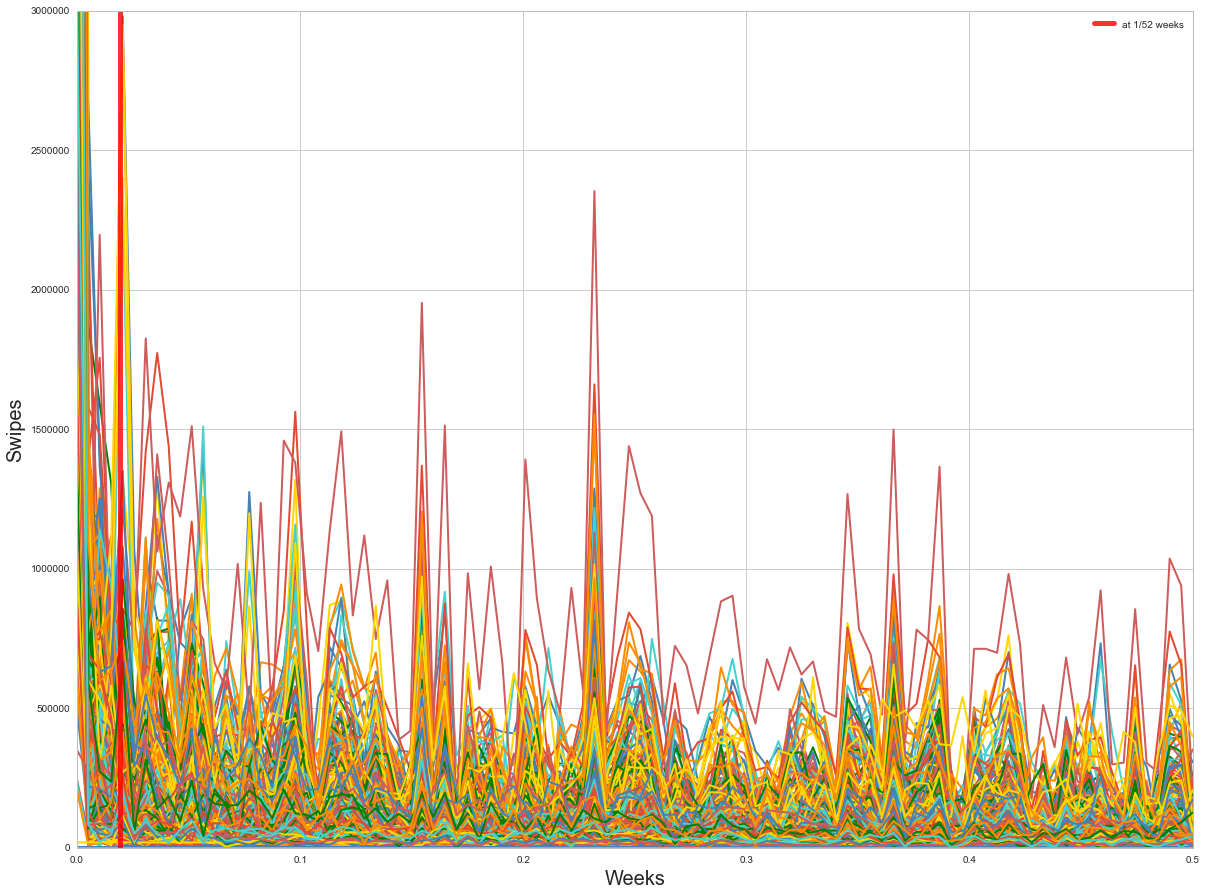

In [121]:
df_ridetype = pd.DataFrame(datasum_ridetype)

freq = np.abs(np.fft.rfft(df_ridetype))
fig = plt.figure(figsize=(20,15))
ax2 = fig.add_subplot(111)
sample_rate = 1
for i in range(600):
    plt.plot(np.fft.rfftfreq(194, 1.0), (freq[i]), '-')

plt.xlabel("Weeks", fontsize=20)
plt.ylabel("Swipes", fontsize=20)
plt.ylim([0, 3e6])
plt.axvline(1.0/52,lw=5, color='red', label='at 1/52 weeks',alpha=0.8)
plt.legend()

In [150]:
ex = []

for i in range(0,600):
    ex.append(sorted(freq[i])[96])

id = []
id = sorted(ex)[-4:]
print (id)
print ("station:", ex.index(id[0]), ex.index(id[1]), ex.index(id[2]), ex.index(id[3]))

[2446320.5879031457, 2931895.8769513383, 2950388.929214194, 2980160.6355953491]
station: 56 150 194 0


# I see that station 0, 56, 150, 194 show the most prominent periodic trend on an annual period (52 weeks).

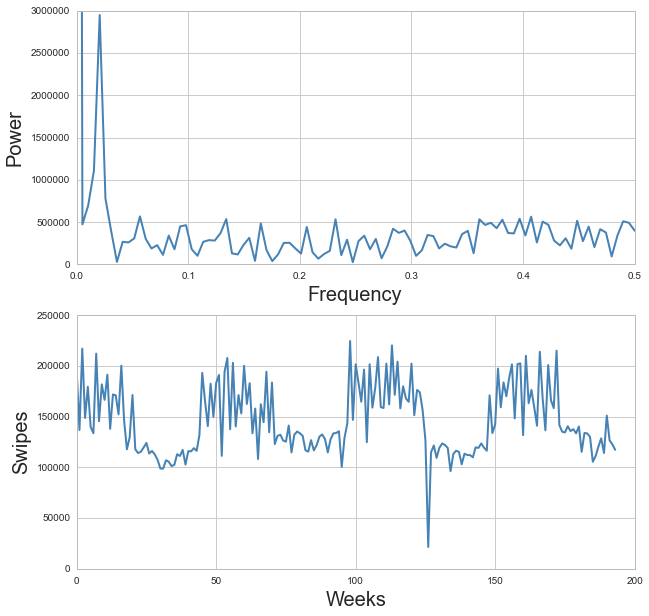

In [151]:
fig=plt.figure(figsize=(10,10))
ax6 = fig.add_subplot(211)
ax6.plot(np.fft.rfftfreq(194, 1.0), (freq[194]), '-', label='station 194')
plt.ylim([0, 3e6])
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Power', fontsize=20)

ax7 = fig.add_subplot(212)
ax7.plot(df_ridetype.loc[194], '-', label='station 194')
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('Swipes', fontsize=20)

# Graphs above show the periodic peaks of station 194.